In [3]:
from __future__ import print_function, division
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

from itertools import chain
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from IPython.core.debugger import set_trace
import itertools
import seaborn as sns
from tqdm import tqdm
import random
import cv2
import json

from natsort import natsorted
import collections
from IPython import display
import pylab as pl

from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch import callbacks
from collections import defaultdict         

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.regression import median_absolute_error, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold
import c3d_wrapper
from data_utils import *
import models
from params import *
from statsmodels.graphics.gofplots import qqplot

# TF model for feature extraction

In [4]:
# pretrained c3d net( tensorflow )
# tf_model = TF_Model()

#visualize_conv_featsmap('7157030_test_0_trial_1', tf_model, layer='conv1')

In [5]:
from skorch.callbacks import Callback
from torchvision.utils import save_image

def to_tensor_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.permute(0,3,1,2)
    x = x.view(x.size(0), 1, 64, 64)
    return x

class Save_Reconstruction_Results(Callback):
    def __init__(self, path):
        self.path = path
        
    def on_epoch_end(self, net, **kwargs):
        for name in ['train', 'valid']:
            dataset = kwargs['dataset_'+name]
            rand_ix = np.random.randint(len(dataset))
            X,y = dataset[rand_ix]
            
            save_dir = os.path.join(self.path, name)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            # target img
            y = y.numpy().transpose(1,2,3,0)  # (maxlen,h,w,3)
            
            # predicted img
            pred = net.predict(X[None,:])[0].transpose(1,2,3,0) # (maxlen,h,w,3)
            
            for sub_name,pic in zip(['target', 'pred'], [y,pred]):
                pic = to_tensor_img(torch.from_numpy(pic))
                save_image(pic, os.path.join(save_dir,sub_name+'.png'))

                
def fetch_samples_from_dataset(dataset):
    X = []
    Y = []
    for item in dataset:
        X.append(item[0].numpy())
        Y.append(item[1].numpy())
        
    return np.array(X), np.array(Y)

def check_array(arr):
    dim = arr.shape[1]
    
    # select non-nan rows
    arr = arr[(~np.isnan(arr)).all(1)].reshape(-1, dim)    
    
    # select non-inf rows
    arr = arr[(arr!=np.inf).all(1)]
    
    return arr

def mape(y_true, y_pred, scaler=None, reduce_all=True):
    if scaler:
        # when skorch callbacks is executed for epoch_scoring
        y_pred = scaler.inverse_transform(y_pred)
        y_true = scaler.inverse_transform(y_true)
        
    with np.errstate(divide='ignore'):
        mape = np.abs((y_true-y_pred)/y_true)

    if reduce_all:
        return check_array(mape).mean()
    else:
        return check_array(mape).mean(0)

def root_mean_squared_error(y_true, y_pred, reduce_all=True):
    if reduce_all:
        return np.sqrt(mean_squared_error(y_true, y_pred))
    else:
        return np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

def record_score(y_pred, y_true, phase, columns, group, save_path="./scores"):
    ixs = np.array([target_columns.index(col) for col in columns])
    
    MAE = mean_absolute_error(y_true[:,ixs], y_pred[:,ixs], multioutput='raw_values')
    MAPE = mape(y_true[:,ixs], y_pred[:,ixs], reduce_all=False)
    R2 = r2_score(y_true[:,ixs], y_pred[:,ixs], multioutput='raw_values')
    print(phase, R2.mean())
    
    MAE_dict = {k:v for k,v in zip(columns, MAE.tolist())}
    MAPE_dict = {k:v for k,v in zip(columns, MAPE.tolist())}
    R2_dict = {k:v for k,v in zip(columns, R2.tolist())}
    
    mae_ = f"MAE : {MAE_dict}"
    mape_ = f"MAPE : {MAPE_dict}"
    r2_ = f"R^2 : {R2_dict}"
    
    msg = "\n".join([mae_, mape_, r2_]).replace("(","\(").replace(")","\)")
    
    log_path = os.path.join(save_path, f'scores_{group}_{phase}.txt')
    
    os.system(f"mkdir -p {save_path}")
    os.system("echo \'{}\' > {}".format(msg, log_path))
    
    print(f'resulting scores have been saved at \"{log_path}\"')

# Custom criterion

In [6]:
from torch.nn.modules.loss import _Loss

class MyCriterion(_Loss):
    def __init__(self):
        super(MyCriterion, self).__init__()
        
    def forward(self, x, y):
        set_trace()
        return nn.MSELoss()(x,y)

# Setup for distributed computing (dask)

In [7]:
from dask.distributed import Client
client = Client('127.0.0.1:8786',
               serializers=['dask', 'pickle'],
                deserializers=['dask', 'msgpack'])
from sklearn.externals import joblib

client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 56 Memory: 135.08 GB


# Hyperparameter search (random search)

In [8]:
from dask_searchcv import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

# for random number generation
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint 

In [9]:
def hyperparams_search(model, super_class, 
                       criterion=nn.modules.loss.MSELoss,
                       ckpt_dir=None, n_splits=5, train_dataset=None, scaler=None):
    
    # init net
    net = super_class(
        model,
        max_epochs=50,
        optimizer=torch.optim.SGD,
        device='cuda',
        criterion=criterion,
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
        callbacks=[('ealy_stop', callbacks.EarlyStopping()),
                   ('lr_scheduler', callbacks.LRScheduler(policy='CyclicLR',
                                                         mode='exp_range',
                                                         base_lr=1e-3,
                                                         gamma=0.97)),
                   ('MAPE', callbacks.EpochScoring(scoring=make_scorer(mape, 
                                                                       scaler = data_dict['scaler']), lower_is_better=True)),
                   ('R2', callbacks.EpochScoring(scoring='r2', lower_is_better=False)),
                   ]
    )

    params = {'batch_size': sp_randint(4,12),
              'callbacks__lr_scheduler__base_lr': sp_uniform(loc=1e-6, scale=1e-2-1e-6),
              'callbacks__lr_scheduler__gamma': sp_uniform(loc=0.5, scale=1.0-0.5),
              'optimizer__weight_decay': sp_uniform(loc=0.0, scale=1e-2),
              'module__num_units': sp_randint(64,256),
              'module__drop_rate': sp_uniform(loc=0.0, scale=0.5),
             }
    
    search = RandomizedSearchCV(net, params, refit=True, cv=n_splits,n_iter=30, iid=False,
                                scoring=make_scorer(r2_score, multioutput='variance_weighted'))
    
    X, y_true = fetch_samples_from_dataset(train_dataset)
    
    search.fit(X, y_true)  
    
    os.system(f'mkdir -p {ckpt_dir}')
    
    print(f'save best model to {ckpt_dir}...!')
    
    search.best_estimator_.save_params(
        f_params=os.path.join(ckpt_dir, 'params.pt'),
        f_optimizer=os.path.join(ckpt_dir, 'optimizer.pt'),
        f_history=os.path.join(ckpt_dir, 'history.json'))
    
    # save best params also !
    json.dump(search.best_params_, open(os.path.join(ckpt_dir, 'best_params.json'), 'w'))
    
    return search

# Prepare dataset

In [10]:
task = 'regression@pretrained'

input_file = "../../preprocess/data/person_detection_and_tracking_results_drop.pkl"
target_file = "../../preprocess/data/targets_dataframe.pkl"

feature_extraction_model=None
feature_layer='conv5'

data_dict = prepare_dataset(input_file, target_file,
                            feature_extraction_model=feature_extraction_model, layer=feature_layer)

train_dataset = dataset_init(task,
                            data_dict['train_X'], data_dict['train_y'],
                            scaler=data_dict['scaler'], name='train')

# holdouf testset for final evaluation
test_dataset = dataset_init(task, 
                            data_dict['test_X'], data_dict['test_y'],
                            scaler=data_dict['scaler'], name='test')

scaler = data_dict['scaler']

# Define training configurations & run!

In [ ]:
super_class = NeuralNetRegressor

if task.split('@')[1]=='fromscratch':
    super_class = AutoEncoderNet

experiments_dict = {}

for name,cr in zip(['MSE', 'MAE', 'Huber'],[nn.modules.loss.MSELoss, nn.modules.loss.L1Loss, nn.modules.loss.SmoothL1Loss]):
    search = hyperparams_search(
                            model=eval('_'.join(task.split('@')).capitalize()),
                            super_class=super_class, criterion=cr,
                            ckpt_dir=f'./models/exp_with_{name}_cost',
                            train_dataset=train_dataset, scaler=scaler)
    experiments_dict[name] = search

# Performance Evaluation for Testset

In [ ]:
def visualize_trend(y_true, y_pred, save_dir, grid_size, figsize, columns, group=None):
    
    nrow,ncol = grid_size
    
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize)
    axes = axes.flatten()
    
#     for ax,col in zip(axes,columns):
        
#         ix = target_columns.index(col)
        
#         sampled_y_true = y_true[:,ix]
#         sampled_y_pred = y_pred[:,ix]

#         sorted_ixs = np.argsort(sampled_y_true)

#         sampled_y_true = sampled_y_true[sorted_ixs]
#         sampled_y_pred = sampled_y_pred[sorted_ixs]
        
#         error = sampled_y_true-sampled_y_pred
        
#         ax.set_title(col+' trace')
#         ax.plot(sampled_y_true, '^', color='orange', label='y_true')
#         ax.plot(sampled_y_pred, label='y_pred')
#         ax.fill_between(np.arange(len(sampled_y_true)), sampled_y_true-error, sampled_y_true,
#         alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
#     linewidth=0, label='margin')
#         ax.legend()
        
    for ax, col in zip(axes,columns):
        ix = target_columns.index(col)
        sns.distplot(y_pred[:,ix], hist=False, label='y_pred', ax=ax)
        sns.distplot(y_true[:,ix], hist=False, label='y_true', ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.legend()
    
    fig.tight_layout()

#     img_path = os.path.join(save_dir, f'trace_plots_{group}.png')
    img_path = os.path.join(save_dir, f'dist_plots_{group}.png')

    os.system(f'mkdir -p {save_dir}')

    plt.savefig(img_path)

In [ ]:
def measure_performance(test_dataset, phase, ckpt_dir, score_dir, figure_dir, scaler=None):
    
    f_best_params = os.path.join(ckpt_dir, 'best_params.json')
    f_params = os.path.join(ckpt_dir, 'params.pt')
    
    # best hyperparams dict
    best_params = json.load(open(f_best_params))
    
    # restore net from ckpt
    net = NeuralNetRegressor(
        module=Regression_pretrained,
        device='cuda',
        **best_params,
    )
    net.initialize()  
    net.load_params(f_params=f_params)
    
    X, y_true = fetch_samples_from_dataset(test_dataset)
    y_pred = net.predict(X)
    
    if scaler:
        y_pred = scaler.inverse_transform(y_pred)
        y_true = scaler.inverse_transform(y_true)
    
    set_trace()
    
    record_score(y_pred, y_true, phase, columns=['Cycle Time(sec)/L', 'Cycle Time(sec)/R',
                             'Stance Time(sec)/L', 'Stance Time(sec)/R',
                             'Double Supp. Time(sec)/L', 'Double Supp. Time(sec)/R',
                             'Swing Time(sec)/L', 'Swing Time(sec)/R'],
                 group='temporal', save_path=score_dir)
    record_score(y_pred, y_true, phase, columns=['Stride Length(cm)/L', 'Stride Length(cm)/R',
                            'HH Base Support(cm)/L', 'HH Base Support(cm)/R'],
                 group='spatial', save_path=score_dir)
    record_score(y_pred, y_true, phase, columns=['Cadence', 'Velocity', 'Functional Amb. Profile'],
                   group='etc', save_path=score_dir)

    report_lerning_process(columns=target_columns,
                           phase=phase, save_dir=figure_dir,
                           y_pred=y_pred,
                           y_true=y_true)
    
    # Temporal params
    visualize_trend(y_true, y_pred, save_dir=figure_dir, grid_size=(4,2), figsize=(20,20),
                    columns=['Cycle Time(sec)/L', 'Cycle Time(sec)/R',
                             'Stance Time(sec)/L', 'Stance Time(sec)/R',
                             'Double Supp. Time(sec)/L', 'Double Supp. Time(sec)/R',
                             'Swing Time(sec)/L', 'Swing Time(sec)/R'],
                   group='temporal')
    
    # Spaitial params
    visualize_trend(y_true, y_pred, save_dir=figure_dir, grid_size=(2,2), figsize=(20,11),
                    columns=['Stride Length(cm)/L', 'Stride Length(cm)/R',
                            'HH Base Support(cm)/L', 'HH Base Support(cm)/R'],
                   group='spatial')
    
    # Etcs
    visualize_trend(y_true, y_pred, save_dir=figure_dir, grid_size=(2,2), figsize=(20,11),
                    columns=['Cadence', 'Velocity', 'Functional Amb. Profile'],
                   group='etc')
    
    

In [ ]:
print(len(set([ s.split('_')[0] for s in train_dataset.y.index ])))
print(len(set([ s.split('_')[0] for s in test_dataset.y.index ])))

In [ ]:
len(test_dataset)

In [ ]:
for name in ['MSE', 'MAE', 'Huber']:
    measure_performance(test_dataset, phase='test', 
                         ckpt_dir=f'./models/exp_with_{name}_cost',
                         score_dir=f'./scores/exp_with_{name}_cost',
                         figure_dir=f'./figures/results/exp_with_{name}_cost',
                         scaler=scaler)

In [ ]:
fig, ax = plt.subplots(figsize=(11,7))
plt.xticks(ha='left')
err_df.plot.bar(rot=-45, ax=ax)

In [ ]:
err_df = pd.DataFrame(errs, columns=target_columns, index=['MSE', 'MAE', 'Huber']).T
err_df

In [ ]:
errs = []
for name in ['MSE', 'MAE', 'Huber']:
    file = f'./scores/exp_with_{name}_cost/test.txt'
    for line in open(file):
        if line:
            err_name, vals = line.replace(' ','').split(':')
            if line.replace(' ','').split(':')[0]=='MAE':
                errs.append(eval(vals))

In [17]:
VHOME = '/data/GaitData/Video'

input_df = pd.read_pickle(input_file)
target_df = pd.read_pickle(target_file)

def check_yolo_detection_ratio(vids):
    logs = []
    for vid in tqdm(vids):
        video_path = os.path.join(VHOME, vid+'.avi')
        s,e = target_df.loc[vid2pid(vid)][['start','end']]
        FPS = cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FPS)
        detection_ratio = len(set(input_df.loc[input_df.vids==vid].loc[input_df.idx.between(s*FPS,e*FPS)].idx)) / ((e-s)*FPS)
        logs.append(detection_ratio)
        if detection_ratio>1.0:
            return input_df.loc[input_df.vids==vid]
    return logs

In [77]:
detection_ratios = check_yolo_detection_ratio(train_dataset.vids+test_dataset.vids)

100%|██████████| 1563/1563 [01:26<00:00, 18.00it/s]


In [79]:
np.min(detection_ratios)

0.6139399546812756

In [135]:
arr = np.array(detection_ratios)
arr[arr<0.95]

array([0.91650068, 0.94156211, 0.84871162, 0.80838565, 0.94276475,
       0.93686507, 0.90352497, 0.86583896, 0.92417412, 0.9341443 ,
       0.92262124, 0.93648697, 0.92296887, 0.91850316, 0.90103823,
       0.93427546, 0.94005859, 0.87392951, 0.92054692, 0.93099395,
       0.93932673, 0.9375026 , 0.94059778, 0.93985415, 0.94993972,
       0.91862352, 0.92174426, 0.90737515, 0.92075107, 0.94173901,
       0.70346686, 0.93187996, 0.94771613, 0.90816734, 0.81614672,
       0.90824378, 0.93052479, 0.94993972, 0.92553585, 0.91333772,
       0.94262681, 0.94569713, 0.94707943, 0.89552605, 0.93964799,
       0.94262542, 0.91637467, 0.93620336, 0.86177886, 0.91245691,
       0.92297771, 0.92998137, 0.90495145, 0.93167933, 0.85389318,
       0.91760712, 0.93236309, 0.93425929, 0.67326946, 0.93537797,
       0.85099631, 0.94926661, 0.89650564, 0.84415968, 0.92282189,
       0.92384004, 0.88278699, 0.93939622, 0.94776515, 0.89711778,
       0.86140851, 0.93642998, 0.94855732, 0.92857446, 0.94716

In [151]:
(1-arr).std()

0.027566341036523924

In [144]:
min(arr)

0.6139399546812756

In [137]:
max(arr)

0.9992805180270207

In [138]:
arr.mean()

0.9842435523218075

In [140]:
arr.std()

0.027566341036523924

In [152]:
np.diff(target_df[['start','end']]).mean()

7.588050775364311

In [142]:
(7.6*0.04)

0.304

In [84]:
0.15/7.5

0.02

In [121]:
np.mean(detection_ratios)

0.9842435523218075

In [122]:
np.std(detection_ratios)

0.027566341036523924

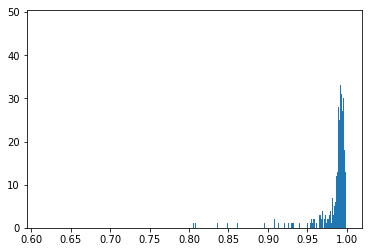

In [118]:
cnt, bins, _ = plt.hist(detection_ratios, bins=len(detection_ratios)); plt.show()

In [129]:
bins[1:][np.where((cnt > 0) & (cnt <len(detection_ratios)*0.1))].mean()

0.9496784808399782

In [133]:
bins[:-1][cnt>0].mean()

0.9494319417719386

In [95]:
cnt[cnt<125].sum()

300.0

In [96]:
len(bins)

101